In [1]:
import pandas as pd
import os

from data_utilities import (download_scPDB,
                            download_SCOPe,
                            download_scPDB_web_pages,
                            parse_scPDB_pages,
                            analyse_current_database,
                            analyse_original_split,
                            split_dataset,
                            get_atoms_properties,
                            visualize_channels)

# Directories

The initial current directory before any execution should at least contain 2 files:

```text
./
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
```

After the complete execution (if all directory names and paths are left as default) the structure will look like:

```text
./
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
|- Data
    |
    |- scPDB
        |- 1a2b_1
            |- protein.mol2
            |- site.mol2
            |- ...(other possible files from scPDB)
        |- ...(all scPDB entries)
    |
    |- SCOPe
        |- 2_08.csv
        |- ...(possibly other SCOPe versions)
    |
    |- Pages
        |- 1a2b_1.txt
        |- ...(all the source codes of scPDB web pages)
    |
    |- Folds
        |- 1.csv
        |- ...(other folds)
        |- test.csv
    |
    |- Atoms
        |- 1a2b_1.csv
        |- ...(csvs with atom coords and props)
```

In [2]:
# Default dirs and paths

SCPDB_DIR = 'Data/scPDB'
SCOPE_DIR = 'Data/SCOPe'
SCOPE_VERSION = '2.08'
PAGES_DIR = 'Data/Pages'
FOLDS_DIR = 'Data/Folds'
ATOMS_DIR = 'Data/Atoms'
MAIN_CSV = 'Data/database.csv'

# Download scPDB DataBase

We need to download at least protein.mol2 and site.mol2 files from scPDB (ideally - the whole database)

        Notice: the complete process might take several hours

Entries with failed downloads will be stored in 'failed_downloads.csv'

        IMPORTANT: the expected size of the scPDB repository is at least 16 Gb

In [3]:
download_scPDB(
    list_of_entries=None,  # entries will be taken from ./all_scpdb_entries.txt
    files_to_load=['protein.mol2', 'site.mol2'],  # minimum these 2 files are required
    skip_existing_files=True,  # do not reload existing files
    version='all',  # download all entries per PDB ID
    dir=SCPDB_DIR  # store to default directory
)

Entries provided: 17594
Files: {'protein.mol2', 'site.mol2'}
Expected size of the downloads: 16.0 Gb


Downloading...: 100%|██████████| 35188/35188 [00:00<00:00, 187798.52it/s]

Failed entries: 0 (files: 0)


# Download SCOPe

We will need SCOPe database further.
The latest stable version as of September'25 is 2.08.

In [4]:
download_SCOPe(
    version=SCOPE_VERSION,  # download the latest version (2.08 by default)
    exist_ok=True,  # skip if already downloaded
    dir=SCOPE_DIR  # store to default directory
)

Version: 2.08
Path: Data/SCOPe/2_08.csv
Version is already in the directory (10.0 Mb)


# Download scPDB Web-Pages

Unfortunately, a lot of valuable information is not available through ordinary downloads from scPDB. Also, downloadable repositary contains files, which are still not in a stable release. Thus, we will search for web-pages of scPDB entries obtained in the first step and only proceed with those.

As this process might be slow, to accelerate the execution, I have provided a list 'excluded_scpdb_entries.txt'. It contains entries which don't have a valid web-page on scPDB.

Entries with failed downloads will be stored in 'failed_web_pages.csv'

        IMPORTANT: the expected size of all reachable pages is at least 600 Mb and the process might take several hours

In [5]:
excluded_entries = open('excluded_scpdb_entries.txt', 'r').read().split('\n')

download_scPDB_web_pages(
    exist_ok=True,  # skip already loaded pages
    dir=PAGES_DIR,  # store to default directory
    scpdb_dir=SCPDB_DIR,  # take entries from default directory
    exclude_entries=excluded_entries  # use acceleration
)

Entries provided (from Data/scPDB): 16034
Expected size of the downloads: 612.0 Mb


Loading scPDB web pages...: 100%|██████████| 16034/16034 [00:00<00:00, 72810.64it/s]

Failed entries: 1


# Parsing Source Codes

Now, when all reachable web-pages are stored, we can carefully parse them to extract information and store it in the main database (csv)

    Notice: it might take several minutes

In [6]:
parse_scPDB_pages(
    list_of_pages=None,  # parse all pages from PAGES_DIR
    pages_dir=PAGES_DIR,  # take pages from default directory
    output_path=MAIN_CSV,  # store resulting CSV to default path
    scope_path=os.path.join(SCOPE_DIR, SCOPE_VERSION.replace('.', '_'))  # take SCOPe from default path
    );

Parsing scPDB web pages
Entries provided (from Data/Pages): 16034


Parsing Source Pages...: 100%|██████████| 16034/16034 [07:42<00:00, 34.70it/s]


Successfully parsed: 16033
Errors occured: 1
SCOPe not found for: 0


Let's have a look at the main database (it have '\t' delimiter)

In [7]:
main_database = pd.read_csv(MAIN_CSV, sep='\t', index_col='scPDB ID')
display(main_database)

,Unnamed: 0,PDB ID,PDB URL,Resolution,Method,Deposition Date,Name,Uniprot ID,AC,Organism,...,Ligand Mass Center (Z),scPDB URL,Protein Mol2 Download URL,Ligand Mol2 Download URL,Site Mol2 Download URL,IFP Download URL,Cavity Download URL,Interaction Download URL,All files Download URL,SCOPe Chain Classes
scPDB ID,,,,,,,,,,,,,,,,,,,,,
2xfi_1,0,2xfi,http://www.rcsb.org/pdb/explore/explore.do?str...,1.73,X-ray,2010-05-24,Beta-secretase 1,BACE1_HUMAN,P56817,Homo sapiens,...,34.72850,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,A b.50.1.2
4g56_2,1,4g56,http://www.rcsb.org/pdb/explore/explore.do?str...,2.95,X-ray,2012-07-17,Protein arginine N-methyltransferase 5,ANM5_XENLA,Q6NUA1,Xenopus laevis,...,65.96920,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,NaN
3qvp_1,2,3qvp,http://www.rcsb.org/pdb/explore/explore.do?str...,1.20,X-ray,2011-02-25,Glucose oxidase,GOX_ASPNG,P13006,Aspergillus niger,...,21.63540,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,A c.3.1.2 / A d.16.1.1
1pj2_5,3,1pj2,http://www.rcsb.org/pdb/explore/explore.do?str...,2.30,X-ray,2003-05-30,"NAD-dependent malic enzyme, mitochondrial",MAOM_HUMAN,P23368,Homo sapiens,...,1.07250,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,A c.2.1.7 / B c.2.1.7 / C c.2.1.7 / D c.2.1.7 ...
2cgv_1,4,2cgv,http://www.rcsb.org/pdb/explore/explore.do?str...,2.60,X-ray,2006-03-09,Serine/threonine-protein kinase Chk1,CHK1_HUMAN,O14757,Homo sapiens,...,17.16640,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,A d.144.1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2ojf_1,16028,2ojf,http://www.rcsb.org/pdb/explore/explore.do?str...,2.10,X-ray,2007-01-12,cAMP-dependent protein kinase catalytic subuni...,KAPCA_BOVIN,P00517,Bos taurus,...,1.53007,http://bioinfo-pharma.u-strasbg.fr/scPDB/SITE=...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,http://bioinfo-pharma.u-strasbg.fr/scPDB/EXPOR...,E d.144.1.7
4pxm_1,16029,4pxm,http://www.rcsb.org/pdb/explore/explore.do?str...,1.90,X

It is difficult to grasp such amount of data, let alone make any conclusions. So, let's aggregate it a bit:

In [8]:
analyse_current_database(MAIN_CSV)

,Value(s)
Metric,
Total Entries,16033
Unique PDB IDs,15250
Unique Uniprot IDs,4690
Mean Resolution (Å),2.136839
Number of Unique Species,927
Most Common Species,"Homo sapiens (5406), Escherichia coli (977), Rattus norvegicus (568)"
Number of Unique Reigns,5
Most Common Reign,"Eukaryota (9199), Bacteria (5308), Viruses (949)"
SCOPe classes present,597


What we can conclude from this table?

1. PDB IDs are not unique, around 800 entries have the IDS already present in the database
2. Unique UniProts (unique proteins themselves) are much less numerous - only about 4700, which makes our database structurally redundant. We will use this fact while data splitting.
3. Mean resolution is more then 2 A, which actually makes the mol2 file coordinates precision a bit overkill, which will help us to accelerate the computations further.
4. Majority of structures come from Eukaryota and around a third - from Homo sapiens
5. Although there are hundrends of SCOPe families, several are largely overpresent in the database (keeping in mind that SCOPe classes refer to chains rather than to complete proteins)
6. About 20% of binding sites contain metal atoms (mostly Mg, Zn or Mn) and only ~9% contain cofactors (mostly NAP, FAD or NDP)
7. There on average 36 residues per binding site, with mean volume being around 800 A^3.
8. Cavity has Hydrophobic and Polar regions on average in the same proportion.

Ligand properties are not of much interest to us in the scope of this research.

# Data Split

In the DeepSite paper we can find supplementary materials with the original data split. Let's see how it looks:

In [9]:
analyse_original_split('original_split.txt', MAIN_CSV)

,Original Length,Currently in scPDB,Currently unique Uniprot IDs
Fold,,,
1,764,618,219
2,764,572,183
3,763,560,180
4,763,588,197
5,763,569,214
6,763,550,173
7,763,593,216
8,763,578,198
9,763,577,176


- Obviously, around 25% of original scPDB entriea are no more present in the repository.
- Also, the number of unique UniProt IDs are even lower. 
- We can also assert (not visible in the table above) that UniProt split is no more unique as it used to be in scPDB 2013, that was used in the original paper.

Which means that we have to perform a new split.
- I decided to allocate a separate test dataset to use for evaluation of domain-specific metrics (it was not done in the original paper)
- test dataset will have ~25% of IDs
- There will be 10 folds for cross-validation as in DeepSite
- UniProt split will be unique for every fold and the test set

In [10]:
split_dataset(
    database_path=MAIN_CSV,  # path to the main database
    folds_dir=FOLDS_DIR,  # store folds to default directory
    test_fraction=0.25,  # 25% for test set
    n_folds=10,  # 10 folds
    seed=1234,  # random seed for reproducibility
    );

Splitting the data
Test Fraction: 0.25; N folds: 10
IDs for final testing: 1172 (total=4689)
IDs for CV: 3517 (total=4689)
IDs per fold: 351 (total=3517)


Creating augmented folds...: 100%|██████████| 11/11 [00:19<00:00,  1.80s/it]



Folds:
	Fold 0: Main entries: 352, Augmented entries: 1299
	Fold 1: Main entries: 352, Augmented entries: 1225
	Fold 2: Main entries: 352, Augmented entries: 1132
	Fold 3: Main entries: 352, Augmented entries: 1030
	Fold 4: Main entries: 352, Augmented entries: 1415
	Fold 5: Main entries: 352, Augmented entries: 1093
	Fold 6: Main entries: 352, Augmented entries: 1067
	Fold 7: Main entries: 351, Augmented entries: 1505
	Fold 8: Main entries: 351, Augmented entries: 937
	Fold 9: Main entries: 351, Augmented entries: 1163
	Final Test: Main entries: 1172, Augmented entries: 4054


Folds size are now much smaller than in the original paper, but:
- the computational complexity of the following steps actually won't allow me to use more data
- if still insufficient, there are also 'augmented folds', which allows several entries per UniProt ID (of course, indide one fold). In such a case, a weight of 1/count will be assigned to every augmented entry to make folds equal in training and evaluation.

Let's look at Fold 0:

In [11]:
pd.read_csv(os.path.join(FOLDS_DIR, '0.csv'))

,Uniprot ID,Main,scPDB IDs,Count
0,SYG_HUMAN,2zt7_1,"['2zt7_1', '2zt5_1']",2
1,ODP1_ECO57,3lq2_2,"['3lq2_2', '3lq4_1']",2
2,FCTA_OXAFO,1vgr_1,"['1vgr_1', '1t4c_2', '1t3z_2', '1p5r_2', '2vjm_1', '1vgq_2']",6
3,THI4_NEUCR,3jsk_8,['3jsk_8'],1
4,D0CBC8_ACIBA,4b4v_1,"['4b4v_1', '4b4w_1']",2
...,...,...,...,...
347,TRM56_PYRHO,2yy8_1,"['2yy8_1', '2yy8_2']",2
348,POLG_DEN2P,1r6a_2,"['1r6a_2', '1l9k_1', '2p1d_2']",3
349,PAP_YEAST,1fa0_3,"['1fa0_3', '2q66_1']",2
350,DNK_DROME,2jcs_2,"['2jcs_2', '2jj8_2', '2vp4_3', '2vqs_2', '2vp0_1', '2vp2_1', '1ot3_7', '1zm7_4', '1oe0_2']",9


- Uniprot ID: unique protein structure identifier
- Main: the main scPDB entry which will be used to represent the unique structure for unaugmented mode
- scPDB IDs: list of all scPDB entries with the given UniProt IDS (can be used in augmented mode)
- Count: number of entries in augmented mode (1/count would be the individual weight of entry in this case)

# Preprocessing

The last step in this section is to analyse MOL2 files.
- MOL2 files contain much more information than we will need for this project
- on the other side, they do not have some chemical channels that we will need (but they can be computed)
- the processing is rather a heavy task, so I decided to run it before the actual sampling and save the processed files in a separate folder

        IMPORTANT: this step might take up to 1 hour and generate around 7 Gb of files

In [12]:
get_atoms_properties(database_path=MAIN_CSV,  # path to the main database
                     exist_ok=True,  # skip already processed files
                     scpdb_dir=SCPDB_DIR,  # default directory to take MOL2 files from
                     atoms_dir=ATOMS_DIR  # default directory to store new CSVs to
                    );

Preprocessing of Mol2 files
Total scPDB entries: 16033
Expected size of CSVs: 7.0 Gb


Preprocessing mol2 files...:  50%|█████     | 8049/16033 [00:00<00:00, 25310.85it/s]

Preprocessing mol2 files...: 100%|██████████| 16033/16033 [00:00<00:00, 35086.15it/s]


Total size of actually generated CSVs: 0 b
Skipped as existing: 16033


Let's take a look at one of the generated files:

In [13]:
pd.read_csv(
    os.path.join(ATOMS_DIR, os.listdir(ATOMS_DIR)[0]),
    sep='\t', index_col='ID'
)

,Element,Detail,X,Y,Z,Charge,Neighbour,Positive Ionizable,Negative Ionizable,Hydrophobic,Aromatic,Donor,Acceptor,Metal
ID,,,,,,,,,,,,,,
1,C,2,20.5010,-28.5900,15.4360,0.0,NaN,0,0,1,0,0,0,0
2,O,2,21.5970,-28.0760,15.6040,0.0,NaN,0,0,0,0,0,1,0
3,C,3,19.5520,-28.0940,14.3160,0.0,NaN,0,0,1,0,0,0,0
4,N,pl3,19.3170,-26.6440,14.3830,0.0,NaN,0,0,0,0,0,1,0
5,C,3,20.0600,-28.4600,12.9180,0.0,NaN,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,H,NaN,20.2257,-52.3181,14.6153,0.0,O,0,0,0,0,1,0,0
4715,H,NaN,19.8947,-50.7738,14.6948,0.0,O,0,0,0,0,1,0,0
4716,O,3,-9.3800,-21.8940,2.3440,0.0,NaN,0,0,0,0,0,1,0


There are the following fields:
- Element (element symbols)
- Detail (additional element type by SYBYL)
- X, Y, Z: coordinates of an atom
- Charge: charge of an atom
- Neighbour (Only for Hydrogen Atoms): the atom to which hydrogen is attached. (It is useful to identify hydrogen donors and to drop carbon-attached hydrogens upon request)
- Positive Ionizable, Negative Ionizable, Hydrophobic, Aromatic, Donor, Acceptor, Metal: seven binary chemical channels that describe an atom as a boolean vector

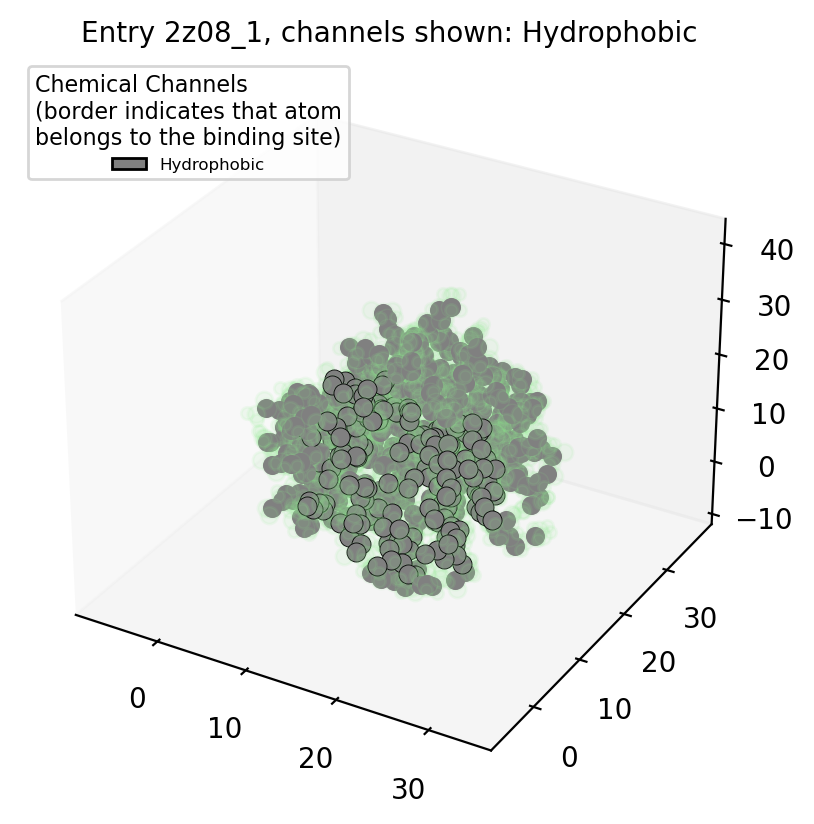

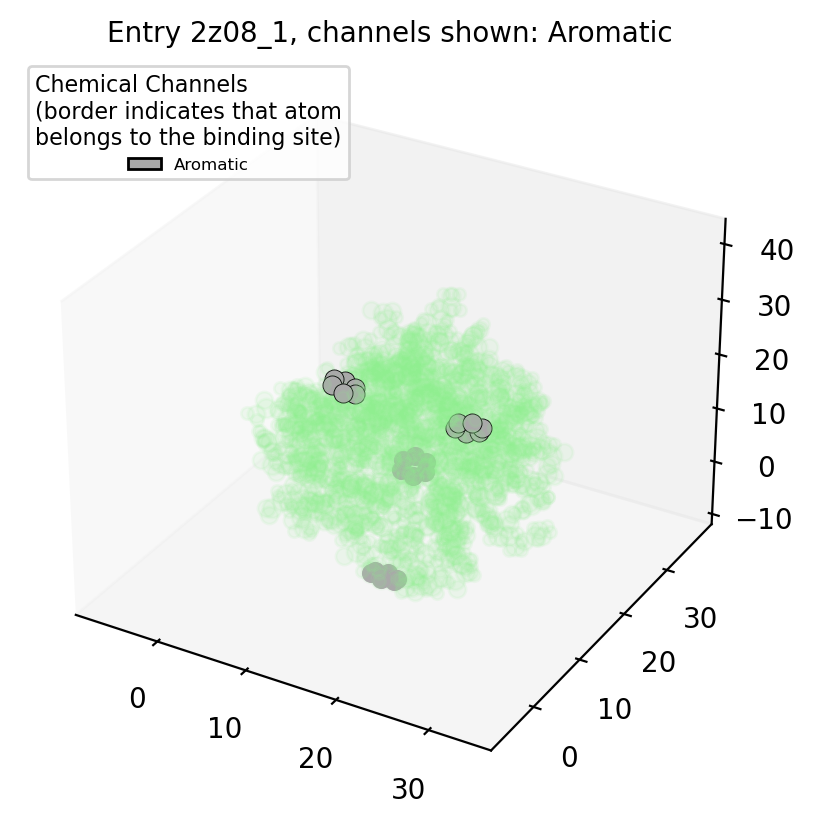

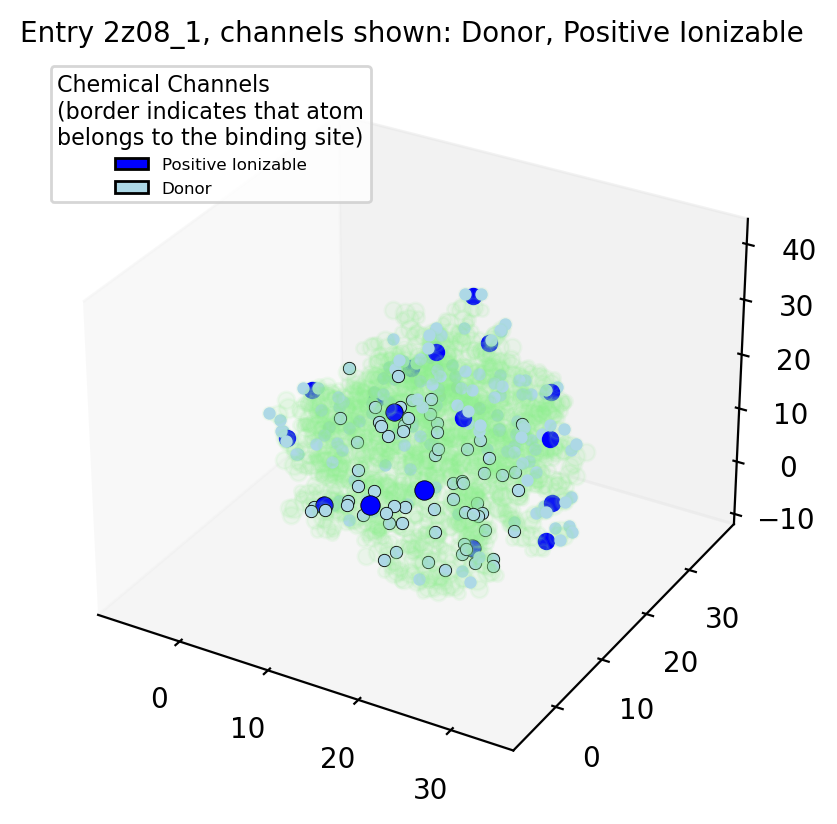

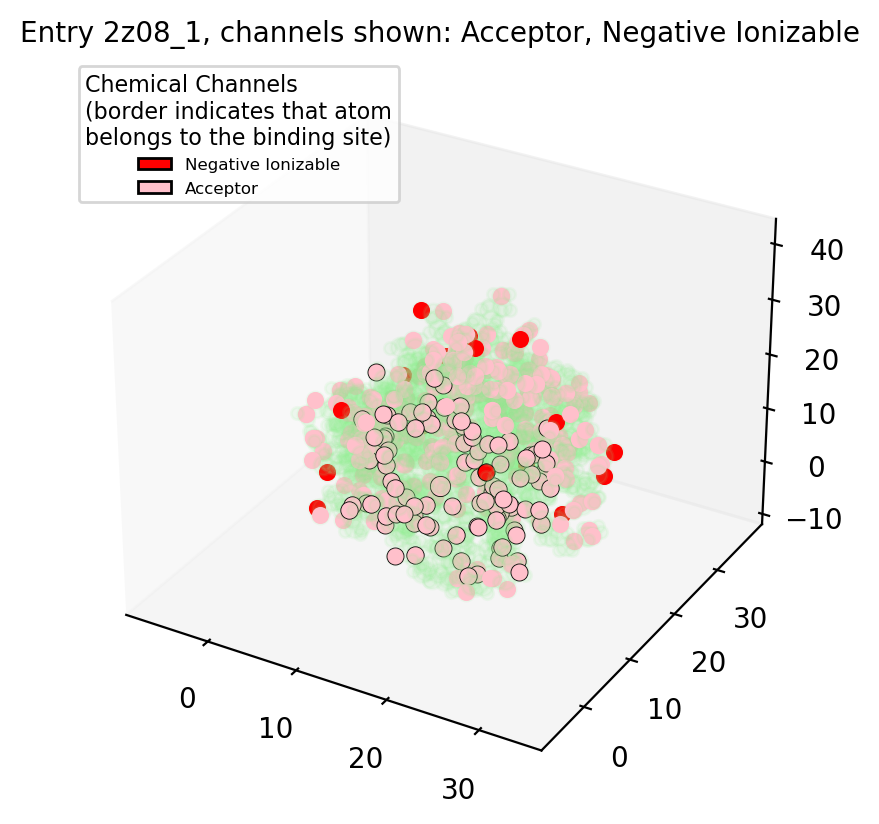

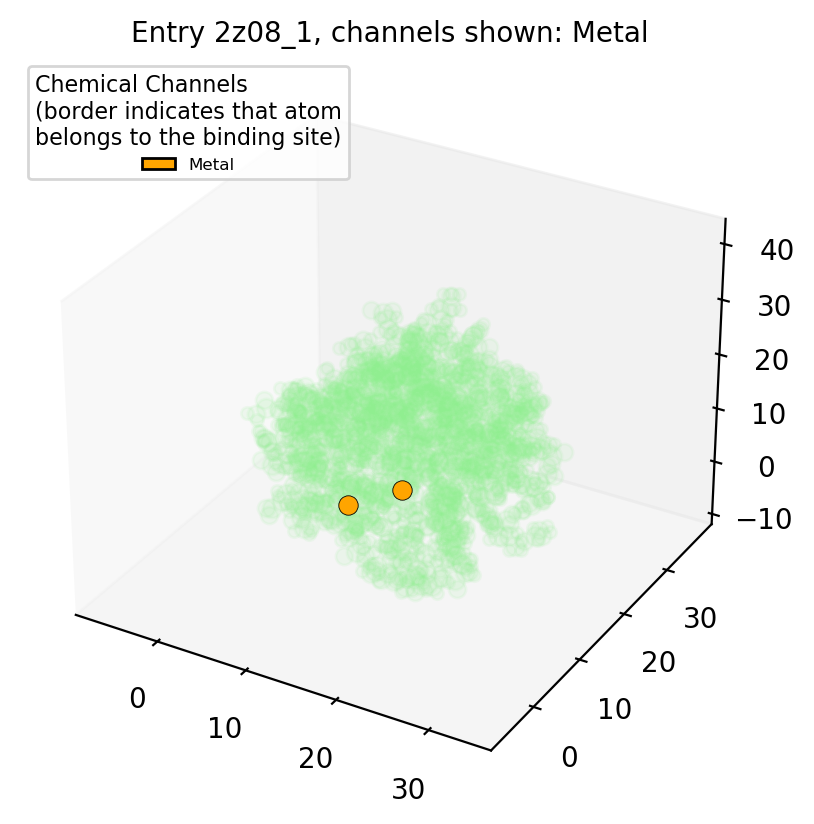

In [14]:
for channel in [['Hydrophobic'], ['Aromatic'], ['Donor', 'Positive Ionizable'], ['Acceptor', 'Negative Ionizable'], [ 'Metal']]:
    visualize_channels('2z08_1', channels=channel, dpi=200)
